In [1]:
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, END
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = 'true' # https://docs.smith.langchain.com/observability
os.environ["LANGSMITH_PROJECT"] = 'demoCrashCourse' # https://docs.smith.langchain.com -> setup Project

In [3]:
# Initialize the model
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b55b440>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b5820f0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
# Graph with tools
@tool
def add(a: float, b: float):
    """Add two numbers"""
    return a + b


@tool
def explain(topic: str) -> str:
    """Explain a given topic in simple terms."""
    # You can use the LLM itself or a static response
    return f"{topic} is a broad concept in AI. (Add more details here.)"


tools = [add, explain]
tool_node = ToolNode(tools=tools)
llm_with_tool = llm.bind_tools(tools=tools)

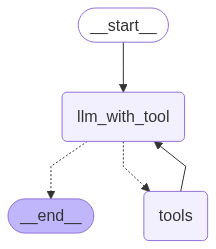

In [6]:
# Node Definition
def call_llm_model(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}


# Graph
builder = StateGraph(State)
builder.add_node("llm_with_tool", call_llm_model)
builder.add_node("tools", tool_node)

# Add Edges
builder.add_edge(START, "llm_with_tool")
builder.add_conditional_edges("llm_with_tool", tools_condition)
builder.add_edge("tools", "llm_with_tool")

# compile the graph
graph = builder.compile()
graph

In [7]:
response = graph.invoke({"messages": "What is the machine learning?"})
response

{'messages': [HumanMessage(content='What is the machine learning?', additional_kwargs={}, response_metadata={}, id='b1339195-0ff0-494f-ac48-14ae67062bf3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cm5vpdhmc', 'function': {'arguments': '{"topic":"machine learning"}', 'name': 'explain'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 993, 'total_tokens': 1059, 'completion_time': 0.049375042, 'prompt_time': 0.110250863, 'queue_time': 0.0023242099999999932, 'total_time': 0.159625905}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7ccab052-1702-4807-991c-3aaafb00a86b-0', tool_calls=[{'name': 'explain', 'args': {'topic': 'machine learning'}, 'id': 'cm5vpdhmc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 993, 'output_tokens': 66, 'total_tokens': 1059}),
  ToolMessage(content='machine learning i

In [8]:
response = graph.invoke({"messages": "What is 2 plus 2?"})
response

{'messages': [HumanMessage(content='What is 2 plus 2?', additional_kwargs={}, response_metadata={}, id='16c11df8-1686-42ba-adc8-d1a79e46524a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n5qnnt79q', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 995, 'total_tokens': 1067, 'completion_time': 0.075135422, 'prompt_time': 0.159817544, 'queue_time': 0.002587791000000006, 'total_time': 0.234952966}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7f633e93-d4b3-45db-8f63-9de90b9f87dc-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'n5qnnt79q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 995, 'output_tokens': 72, 'total_tokens': 1067}),
  ToolMessage(content='4.0', name='add', id='2389cc16-1afe-405a-b8c8-c63143447877', tool_c

In [9]:
response = graph.invoke({"messages": "What is 5 plus 2?"})
response

{'messages': [HumanMessage(content='What is 5 plus 2?', additional_kwargs={}, response_metadata={}, id='d6e1c073-f18f-454b-ae6e-aa35066b47c5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wzjy5n4zq', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 995, 'total_tokens': 1067, 'completion_time': 0.053706119, 'prompt_time': 0.109994765, 'queue_time': 0.0023246560000000083, 'total_time': 0.163700884}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d47e7228-ce95-4d4a-bfb8-8ab7223734a2-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 2}, 'id': 'wzjy5n4zq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 995, 'output_tokens': 72, 'total_tokens': 1067}),
  ToolMessage(content='7.0', name='add', id='f456dcaa-fe72-4e6b-a581-466f9c969d48', tool_